In [5]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import copy
import gpu
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [6]:
# Wavefunction generation
from scf_runs import run_lda_he, run_casci
scf_checkfile, opt_checkfile, mf_lda = run_lda_he()
ci_checkfile, mc, opt_chkfile, vmc_chkfile = run_casci(scf_checkfile, nroots=1, ncas = 2)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.86151422722833  <S^2> = 2.4424907e-15  2S+1 = 1
LDA
converged SCF energy = -2.83456474290722  <S^2> = 3.1086245e-15  2S+1 = 1
CASCI nelecas up/down (1, 1)
CASCI E = -2.86531899726653  E(CI) = -2.86531899726653  S^2 = 0.0000000
Available output from CASCI: <KeysViewHDF5 ['ci', 'fci', 'mc_mo_energy', 'mf_mo_energy', 'mo_coeff', 'mo_occ', 'ncas', 'ncore', 'nelecas']>


In [196]:
import importlib, recipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools, bosonslater_wf_based
modules = [recipes, bosonrecipes, bosonrecipes, bosonslater, bosonaccumulators, bosonwftools] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)


wf = bosonslater.BosonWF(mf_lda.mol, mf_lda, mc)
wf_wfb = bosonslater_wf_based.BosonWF(mf_lda.mol, mf_lda, mc)

from bosonwftools import generate_boson_wf
wfj, _ = generate_boson_wf(mf_lda.mol, mf_lda, mc=mc)
jastrow_wf = wfj.wf_factors[-1]

configs = bosonrecipes.initial_guess(mf_lda.mol, 100)
_ = wf.recompute(configs)
_ = wf_wfb.recompute(configs)
_ = wfj.recompute(configs)      
configs.configs.shape

Will optimize:  dict_keys(['wf2acoeff', 'wf2bcoeff'])


(100, 2, 3)

In [239]:
tol = 1E-1

nconf, nelec, _ = configs.configs.shape

def is_equal(a, b, tag=None):
    result = (np.abs(a-b) < tol).all()
    if not result:
        print(tag, result, 'diff', np.max(np.abs(a-b)), 'a', np.max(np.abs(a)), 'b', np.max(np.abs(b)))
    else:
        print(tag, result)
    return result
    
def wf_based_acc(boson_wf, configs):
    _, nelec, _ = configs.configs.shape

    for wfi in boson_wf.wfs:
        wfi.recompute(configs)
        
    phib_sign, phib_logval = boson_wf.value() # Eq. 4
    phib_val = phib_sign * np.nan_to_num(np.exp(phib_logval)) #[c]

    psibt_sign, psibt_logval = wf.value() # Eq. 4
    psibt_val = psibt_sign * np.nan_to_num(np.exp(psibt_logval)) #[c]

    phase, log_vals = [
            np.nan_to_num(np.array(x)) for x in zip(*[wfi.value() for wfi in boson_wf.wfs])
        ]

    psi = phase * np.nan_to_num(np.exp(log_vals))
    
    ovlp_ij = np.einsum("lc,nc, c->cln", psi.conj(), psi, (1./phib_val**2))
    
    
    wfn_inner = np.zeros(psi.shape)
    for ind, wfi in enumerate(boson_wf.wfs):  
        wfi_sign, wfi_value = wfi.value()
        nb_ratio = wfi_sign * np.exp(wfi_value - phib_logval)
        grad = 0
        for e in range(nelec):
            grad_phi_n = wfi.gradient(e, configs.electron(e))
            grad_b = boson_wf.gradient(e, configs.electron(e))
            grad_j = jastrow_wf.gradient(e, configs.electron(e))
            grad += np.einsum("dc,dc->c", grad_phi_n - grad_b, grad_j)
        wfn_inner[ind] = np.einsum("c, c -> c", nb_ratio, grad)
    delta = np.einsum("lc, c, nc -> cln", psi, 1./phib_val, wfn_inner)
    
    return delta
    # # nb_ratio = phase * np.exp(log_vals - phib_logval)
    
    # # grad = 0
    # # for e in range(nelec):
    # #     epos = configs.electron(e)
    # #     grad_phi_n = boson_wf.gradient_dets(e, epos)
    # #     grad_b     = boson_wf.gradient(e, epos)
    # #     grad_j = jastrow_wf.gradient(e, configs.electron(e))
    # #     grad += np.einsum("nec,ec->nc", grad_phi_n - grad_b, grad_j)
    # # wfn_inner = np.einsum("nc,nc->nc", nb_ratio, grad)

    
    # delta = 0
    # results = {'delta':delta, 'ovlp_ij': ovlp_ij}   
    # return results


# def new_acc2(boson_wf):
#     _, nelec, _ = configs.configs.shape

#     phib_sign, phib_logval = boson_wf.value() # Eq. 4
#     phib_val = phib_sign * np.nan_to_num(np.exp(phib_logval)) #[c]
    
#     phase, log_vals = boson_wf.value_dets()

#     # updets = boson_wf._dets[0][:, :, boson_wf._det_map[0]]
#     # dndets = boson_wf._dets[1][:, :, boson_wf._det_map[1]]

#     # upref = gpu.cp.amax(updets[1]).real
#     # dnref = gpu.cp.amax(dndets[1]).real
#     # import pdb
#     # pdb.set_trace()
#     # log_vals = (updets[1] + dndets[1])
#     # phase = updets[0] * dndets[0]
    
#     psi = phase * np.nan_to_num(np.exp(log_vals))
    
#     ovlp_ij = np.einsum("cl,cn, c->cln", psi.conj(), psi, (1./phib_val**2))
#     return ovlp_ij


def new_acc(boson_wf):
    _, nelec, _ = configs.configs.shape

    phib_sign, phib_logval = boson_wf.value() # Eq. 4
    phib_val = phib_sign * np.nan_to_num(np.exp(phib_logval)) #[c]
    
    phase, log_vals = boson_wf.value_dets()

    # updets = boson_wf._dets[0][:, :, boson_wf._det_map[0]]
    # dndets = boson_wf._dets[1][:, :, boson_wf._det_map[1]]

    # upref = gpu.cp.amax(updets[1]).real
    # dnref = gpu.cp.amax(dndets[1]).real
    # det_coeffs = boson_wf.myparameters['det_coeff']
    
    # logvals = (updets[1] - upref + dndets[1] - dnref)
    # phases = updets[0] * dndets[0]
    
    # wf_val = gpu.cp.einsum("id->di", phases * gpu.cp.exp(logvals))
    
    # phase = np.nan_to_num(wf_val / gpu.cp.abs(wf_val))
    # log_vals = np.nan_to_num(gpu.cp.log(gpu.cp.abs(wf_val)) + (upref + dnref))        

    psi = phase * np.nan_to_num(np.exp(log_vals))
    
    ovlp_ij = np.einsum("cl,cn, c->cln", psi.conj(), psi, (1./phib_val**2))
    
    wfn_inner = np.zeros(psi.shape)
    nb_ratio = phase.T * np.nan_to_num(np.exp(log_vals.T - phib_logval))
    grad = 0
    for e in range(nelec):
        epos = configs.electron(e)
        grad_phi_n = boson_wf.gradient_dets(e, epos)
        grad_b     = boson_wf.gradient(e, epos)
        grad_j = jastrow_wf.gradient(e, configs.electron(e))
        grad += np.einsum("nec,ec->nc", grad_phi_n - grad_b, grad_j)
    wfn_inner = np.einsum("nc,nc->nc", nb_ratio, grad)
    # import pdb
    # pdb.set_trace()
    
    delta = np.einsum("cl, c, nc -> cln", psi, 1./phib_val, wfn_inner)
    return delta
    # # results = {'delta':delta, 'ovlp_ij': ovlp_ij}    
    # return results    

In [240]:
wfb_res = wf_based_acc(wf_wfb, configs)

In [241]:
new_res = new_acc(wf)
# new_res2 = new_acc2(wf)

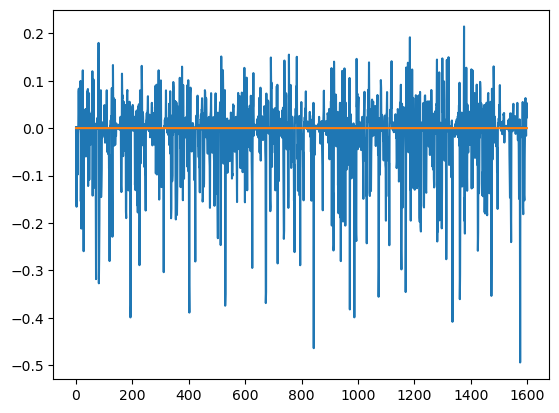

In [243]:
a = (wfb_res-new_res).flatten()
b = new_res.flatten()
plt.plot(b)
plt.plot(a)


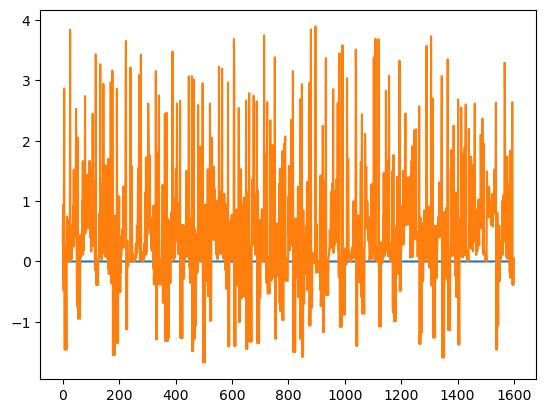

In [177]:
a = (new_res2-new_res).flatten()
b = new_res.flatten()
plt.plot(a)
plt.plot(b)

In [68]:
(wfb_res['ovlp_ij']-new_res['ovlp_ij'])[0]

array([[-2.77555756e-16, -6.66133815e-16, -3.13548574e-01,
        -9.57791258e-01],
       [-6.66133815e-16, -4.44089210e-16, -9.57791258e-01,
        -2.92574794e+00],
       [-3.13548574e-01, -9.57791258e-01, -2.08166817e-16,
        -2.77555756e-16],
       [-9.57791258e-01, -2.92574794e+00, -2.77555756e-16,
         0.00000000e+00]])